# Step 5.3 Parameter Tuning with C
In this notebook, we tune the SVC model with three different values for the C parameter.

In [1]:
import pandas as pd
import numpy as np
from pandas import plotting
import matplotlib.pyplot as plt
from datetime import datetime as dt
import io, s3fs, json, traceback
pd.set_option('display.max_columns', None)
print('Program run at', dt.now())

Program run at 2021-06-26 10:59:52.391908


Load modules, data, and write functions

In [2]:
# Ignore warnings from scikit-learn to make this notebook a bit nicer
import warnings
warnings.simplefilter('ignore')

# Models may be implemented as pipelines
from sklearn.pipeline import Pipeline

# Used to divide our dataseets into train/test splits
# Data will be randomly shuffled so running this notebook multiple times may lead to different results
from sklearn.model_selection import train_test_split as tts

# Visual analysis of model performance
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot
from yellowbrick.classifier import ROCAUC

# Set the default figure size for matplotlib
plt.rcParams['figure.figsize'] = (9, 6)

#Model toolset
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, NuSVC, SVC

#Pipeline toolset
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split as tts

#Evaluation toolset
from sklearn.model_selection import StratifiedKFold, cross_val_score
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import FeatureImportances
from yellowbrick.target import ClassBalance
from sklearn.metrics import accuracy_score


In [3]:
est_rmv = pd.read_csv('s3://bleeding-hearts/workingdata/est_rmv.csv')

In [4]:
cat_labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']

In [5]:
categorical = make_column_selector(dtype_include=np.object)
numeric = make_column_selector(dtype_include=np.int64)
numeric2 = make_column_selector(dtype_include=np.float64)

In [6]:
def train_test(X,y):
    X_train, X_test, y_train, y_test = tts(X, y, test_size=.2)
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

In [7]:
def score_model(X, y, estimator, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])

    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)

    expected  = y
    predicted = model.predict(X)
    

    # Compute and return F1 (harmonic mean of precision and recall)
    print("F1 SCORE {}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted,average='micro')))

In [8]:
def visualize_model(X, y, estimator,label_lst, **kwargs):
    """
    Test various estimators.
    """
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=label_lst,
        cmap="YlGn", size=(600, 360), support=True, **kwargs
    )
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()

In [9]:
def conf_matrix(X,y,estimator,label_lst, **kwargs):
    y = LabelEncoder().fit_transform(y)
    model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])


    #Create the train and test data
    X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)
    model.fit(X, y)
    # Instantiate the visualizer with the classification model
    confusion_matrix(
        model,
        X_train, y_train, X_test, y_test,
        classes=label_lst
    ).show()
    #plt.tight_layout()
    #plt.show()

In [10]:
def roc_auc(X,y,estimator,**kwargs):
        y = LabelEncoder().fit_transform(y)
        model = Pipeline([
    ("columns", ColumnTransformer([
        ('onehot', OneHotEncoder(), categorical),
        ('scalar', RobustScaler(), numeric),
        ('scalar2', RobustScaler(), numeric2),
    ], remainder='drop')),
        ("imputer",SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('estimator', estimator)
])
        #Create the train and test data
        X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)
    # Instantiate the visualizer with the classification model

        visualizer = ROCAUC(model, classes=cat_labels)

        visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
        visualizer.score(X_test, y_test)        # Evaluate the model on the test data
        visualizer.show()                       # Finalize and show the figure

Different values of C below - 1, 10, and 100

In [11]:
models = [
    SVC(
        kernel='linear',    #How does using a linear kernel affect model performance?
        C=1.0,
        gamma='scale'),
    SVC(
        kernel='linear',
        C=10,
        gamma='scale'),
    SVC(kernel='linear',
        C=100,
        gamma='scale'
    
    )]

Run the model with different C parameters below. First output is C of 1, second is C of 10, and third is C of 100.

(14566, 64) (14566,)
(3642, 64) (3642,)
F1 SCORE SVC: 0.6765707381370826


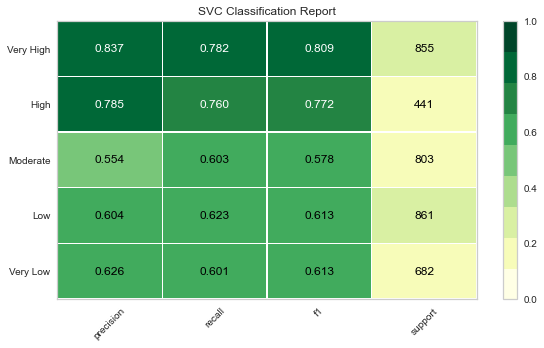

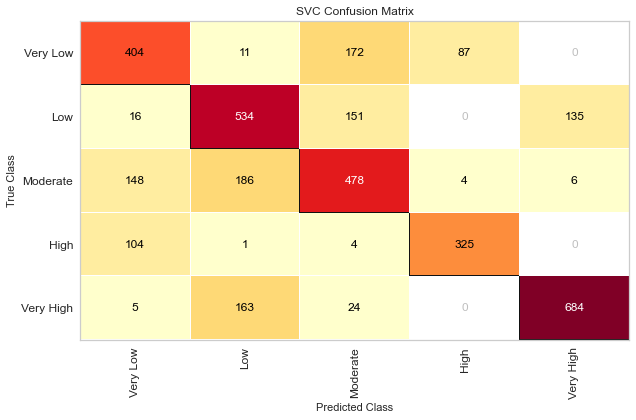

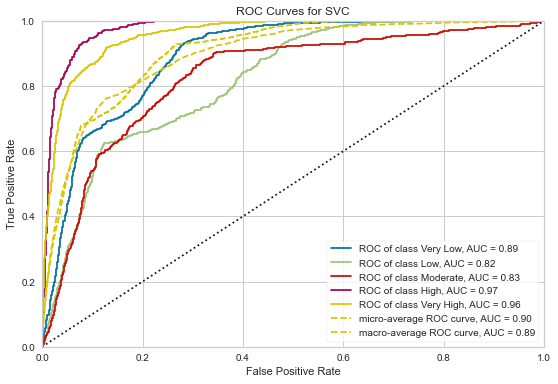

F1 SCORE SVC: 0.6765707381370826


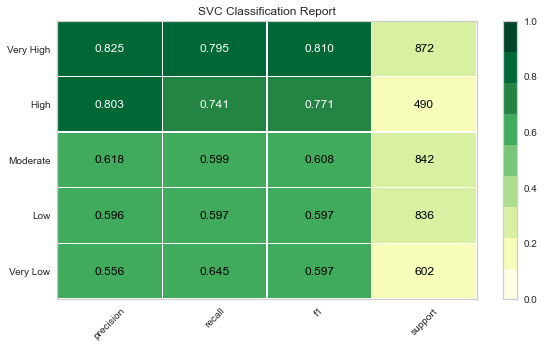

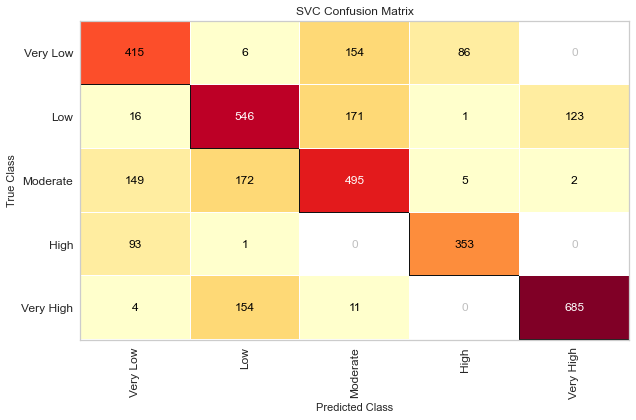

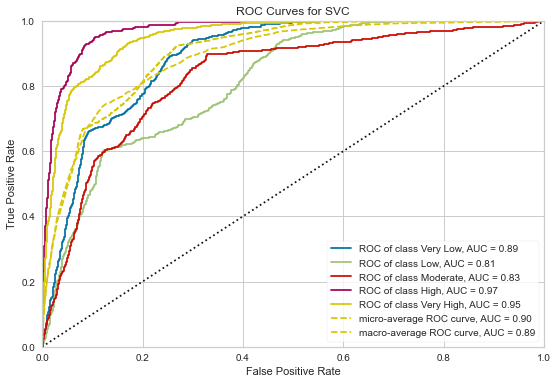

F1 SCORE SVC: 0.6734402460456942


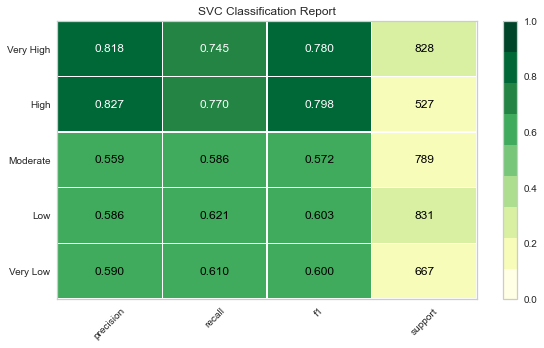

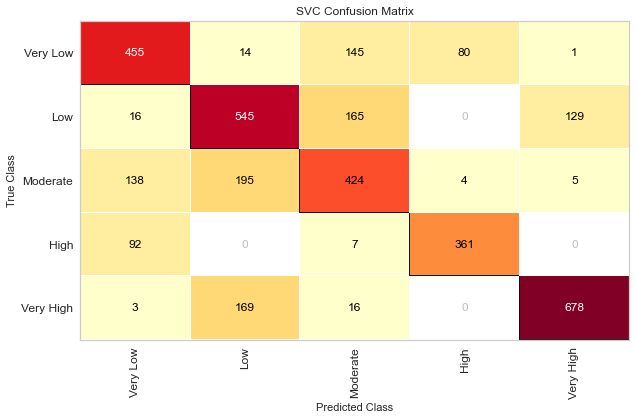

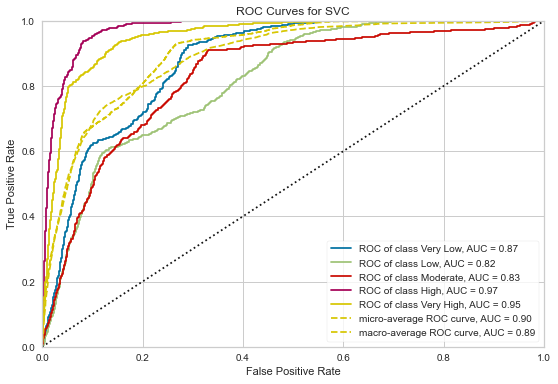

In [12]:
X = est_rmv.loc[:, est_rmv.columns != 'Child Opportunity Levels, overall COI, nationally-normed']
y = est_rmv['Child Opportunity Levels, overall COI, nationally-normed']
train_test(X,y)
for model in models:
    try:
        score_model(X, y, model)
        visualize_model(X, y, model, cat_labels)
        conf_matrix(X, y, model,cat_labels)
        roc_auc(X, y, model)
    except Exception as exc:
        print(model, 
              traceback.format_exc(), 
              exc)